In [40]:
import sys
sys.path.insert(0, 'C:/Users/Franco/Documents/AnacondaProjects/Predicting_Conflicts')
from Libs import *
sys.path.insert(0, 'C:/Users/Franco/Documents/AnacondaProjects/Predicting_Conflicts/DataAnalysis/')
from DataSplitNew import *

#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.model_selection import cross_val_score
#from time import time
#from scipy.stats import randint as sp_randint
#
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
##Common Model Algorithms
#from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
#
##Common Model Helpers
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#from sklearn import feature_selection
#from sklearn import model_selection
#from sklearn import metrics
#
##Visualization
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
#import seaborn as sns
#from pandas.tools.plotting import scatter_matrix
#
#import warnings
#warnings.filterwarnings('ignore')
#
#import time
#import itertools
#from tqdm import tqdm

In [7]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [8]:
df_prim = df_final.copy()
df_prim.drop('country', axis=1, inplace=True)
df_prim = df_prim.loc[df_prim['year'] < 2017, :]

df_validation = df_prim.sample(frac = 0.1)
df = df_prim.copy()
df.drop(df_validation.index, inplace=True)

data_cleaner = [df_validation, df]

In [9]:
print(len(df))
print(len(df_validation))
print(len(df_prim))

7421
824
8245


In [10]:
df['Weapons'].describe()

count    7421.00
mean      305.27
std      1642.74
min         0.00
25%         0.00
50%         0.00
75%        72.00
max     50350.00
Name: Weapons, dtype: float64

In [11]:
#skewness and kurtosis
print("Skewness: %f" % df['conflict'].skew())
print("Kurtosis: %f" % df['conflict'].kurt())

Skewness: 1.341378
Kurtosis: -0.200760


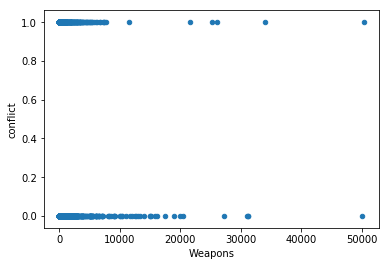

In [13]:
#scatter plot grlivarea/saleprice
var = 'Weapons'
data = pd.concat([df['conflict'], df[var]], axis=1)
data.plot.scatter(x=var, y='conflict');

In [15]:
df_final[df_final['Weapons'] > 40000].sort_values('year')

,year,country,Tools,Vehicles,Weapons,Prom Tools,Prom Vehicles,Prom Weapons,amount,conflict,conflict-1-to-3,conflict-4-to-6,conflict-7-to-9,Prom USA,country encoded
6636,1958,United States,0.00,0.00,50000.00,0.00,16.67,0.00,0.00,0,0,0,1,0.00,199
1314,1979,India,18.00,396.00,50350.00,11.33,334.67,318.00,0.00,1,0,0,1,0.00,82


In [21]:
Target = ['conflict']
cols = ['year', 'Tools', 'Vehicles', 'Weapons', 
        'Prom Tools', 'Prom Vehicles', 'Prom Weapons', 'amount',
       'conflict-1-to-3', 'conflict-4-to-6', 'conflict-7-to-9', 'Prom USA',
       'country encoded']
        #, 'Tools_bin_code',
       #'Vehicles_bin_code', 'Weapons_bin_code', 'Prom Tools_bin_code', 'Prom Vehicles_bin_code',
       #'Prom Weapons_bin_code', 'amount_bin_code', 'Prom USA_bin_code']

In [22]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7421 entries, 0 to 8982
Data columns (total 13 columns):
year               7421 non-null int64
Tools              7421 non-null float64
Vehicles           7421 non-null float64
Weapons            7421 non-null float64
Prom Tools         7421 non-null float64
Prom Vehicles      7421 non-null float64
Prom Weapons       7421 non-null float64
amount             7421 non-null float64
conflict-1-to-3    7421 non-null int64
conflict-4-to-6    7421 non-null int64
conflict-7-to-9    7421 non-null int64
Prom USA           7421 non-null float64
country encoded    7421 non-null int64
dtypes: float64(8), int64(5)
memory usage: 811.7 KB


In [23]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df[cols], df[Target] , random_state = 0)

In [24]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0 )

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' , 'MLA Validation', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [25]:
#create table to compare MLA predictions
#MLA_predict = df[Target]

In [26]:
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, df[cols], df[Target].values.ravel(), cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    
    #save MLA predictions - see section 6 for usage
    alg.fit(df[cols], df[Target].values.ravel())
    #MLA_predict[MLA_name] = accuracy_score(df_validation[Target], alg.predict(df_validation[cols]))
    MLA_compare.loc[row_index, 'MLA Validation'] = accuracy_score(df_validation[Target], alg.predict(df_validation[cols]))
    
    row_index+=1

In [27]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Validation,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.99,0.91,0.01,0.92,0.07
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.99,0.91,0.01,0.93,0.24
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1.00,0.91,0.01,0.93,0.06
20,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.92,0.91,0.01,0.92,0.65
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.92,0.91,0.01,0.92,0.45
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.89,0.89,0.01,0.91,0.26
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.88,0.89,0.01,0.90,0.01
16,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1.00,0.88,0.02,0.91,0.04
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.87,0.87,0.02,0.87,0.00
17,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1.00,0.87,0.02,0.88,0.01


Text(0,0.5,'Algorithm')

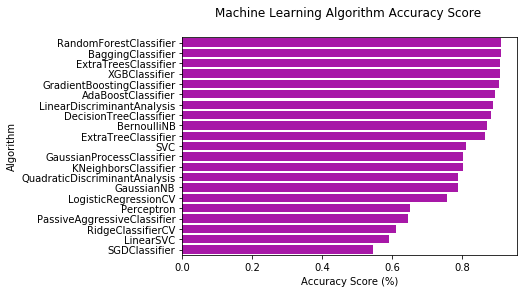

In [28]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [29]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, df[cols], df[Target], cv  = cv_split)
dtree.fit(df[cols], df[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(df[cols], df[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


#duplicates gridsearchcv
#tune_results = model_selection.cross_validate(tune_model, df[cols], df[Target], cv  = cv_split)

#print('AFTER DT Parameters: ', tune_model.best_params_)
#print("AFTER DT Training set score mean: {:.2f}". format(tune_results['train_score'].mean()*100)) 
#print("AFTER DT Test set score mean: {:.2f}". format(tune_results['test_score'].mean()*100))
#print("AFTER DT Test set score min: {:.2f}". format(tune_results['test_score'].min()*100))
#print('-'*10)


BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 100.00
BEFORE DT Test w/bin score mean: 88.53
BEFORE DT Test w/bin score 3*std: +/- 2.19
----------
AFTER DT Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'random_state': 0}
AFTER DT Training w/bin score mean: 94.67
AFTER DT Test w/bin score mean: 91.78
AFTER DT Test w/bin score 3*std: +/- 2.15
----------


In [30]:
#base model
print('BEFORE DT RFE Training Shape Old: ', df[cols].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[cols].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(df[cols], df[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = df[cols].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, df[X_rfe], df[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(df[X_rfe], df[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (7421, 13)
BEFORE DT RFE Training Columns Old:  ['year' 'Tools' 'Vehicles' 'Weapons' 'Prom Tools' 'Prom Vehicles'
 'Prom Weapons' 'amount' 'conflict-1-to-3' 'conflict-4-to-6'
 'conflict-7-to-9' 'Prom USA' 'country encoded']
BEFORE DT RFE Training w/bin score mean: 100.00
BEFORE DT RFE Test w/bin score mean: 88.53
BEFORE DT RFE Test w/bin score 3*std: +/- 2.19
----------
AFTER DT RFE Training Shape New:  (7421, 3)
AFTER DT RFE Training Columns New:  ['year' 'conflict-1-to-3' 'country encoded']
AFTER DT RFE Training w/bin score mean: 100.00
AFTER DT RFE Test w/bin score mean: 89.70
AFTER DT RFE Test w/bin score 3*std: +/- 2.27
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 8, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 91.68
AFTER DT RFE Tuned Test w/bin score mean: 90.46
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 1.70
----------


In [36]:
#correlation_heatmap(MLA_predict)

In [32]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, df[cols], df[Target].values.ravel(), cv  = cv_split)
vote_hard.fit(df[cols], df[Target])

print("Hard Voting Training score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, df[cols], df[Target].values.ravel(), cv  = cv_split)
vote_soft.fit(df[cols], df[Target])

print("Soft Voting Training score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)


Hard Voting Training w/bin score mean: 95.48
Hard Voting Test w/bin score mean: 89.95
Hard Voting Test w/bin score 3*std: +/- 1.29
----------
Soft Voting Training w/bin score mean: 97.70
Soft Voting Test w/bin score mean: 90.84
Soft Voting Test w/bin score 3*std: +/- 0.85
----------


In [33]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(df[cols], df[Target].values.ravel())
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 149.29 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.5, 'n_estimators': 300, 'random_state': 0} with a runtime of 345.92 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300, 'random_state': 0} with a runtime of 212.64 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 338.24 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': None, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 389.68 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 1269.41 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'rand

In [34]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, df[cols], df[Target].values.ravel(), cv  = cv_split)
grid_hard.fit(df[cols], df[Target].values.ravel())

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, df[cols], df[Target].values.ravel(), cv  = cv_split)
grid_soft.fit(df[cols], df[Target].values.ravel())

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 98.01
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 91.36
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 1.04
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 98.74
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 91.48
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 0.94
----------


In [39]:
print("{:.2f}".format(accuracy_score(df_validation[Target], grid_hard.predict(df_validation[cols]))))
print("{:.2f}".format(accuracy_score(df_validation[Target], grid_soft.predict(df_validation[cols]))))

0.92
0.93
